### 设计环境

#### env_data

In [1]:
import pandas as pd


def fix_data(path):
    tmp = pd.read_csv(path, encoding="gbk", engine='python')
    tmp.rename(columns={'Unnamed: 0': 'trading_time'}, inplace=True)
    tmp['trading_point'] = pd.to_datetime(tmp.trading_time)
    del tmp['trading_time']
    return tmp.set_index(tmp.trading_point)


def high2low(tmp, freq):
    """处理从RiceQuant下载的分钟线数据，
    从分钟线数据合成低频数据
    2017-08-11
    """
    # 分别处理bar数据
    tmp_open = tmp['open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['high'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)

    # 处理成交量
    tmp_volume = tmp['volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)

    return pd.concat([tmp_price, tmp_volume], axis=1)

#### env_factor

In [2]:
import pandas as pd
import talib


def get_factors(index,
                opening,
                closing,
                highest,
                lowest,
                volume,
                rolling=26,
                drop=False,
                normalization=True):
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index

    # 累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    # 用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(highest, lowest, closing, volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(highest, lowest, closing, volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(highest, lowest, closing, timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(highest, lowest, closing, timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(closing, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，
    # 帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    # Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(highest, lowest, timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(highest, lowest, timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    # 是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14'] = talib.ATR(highest, lowest, closing, timeperiod=14)
    tmp['ATR6'] = talib.ATR(highest, lowest, closing, timeperiod=6)

    # 布林带
    tmp['Boll_Up'], tmp['Boll_Mid'], tmp['Boll_Down'] = \
        talib.BBANDS(closing, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(opening, highest, lowest, closing)

    # 5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(highest, lowest, closing, timeperiod=5)
    tmp['CCI10'] = talib.CCI(highest, lowest, closing, timeperiod=10)
    tmp['CCI20'] = talib.CCI(highest, lowest, closing, timeperiod=20)
    tmp['CCI88'] = talib.CCI(highest, lowest, closing, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如
    # 相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(closing, timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(closing, timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(closing, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(closing, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(closing, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(highest, lowest, closing, timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(closing, timeperiod=6)
    tmp['EMA12'] = talib.EMA(closing, timeperiod=12)
    tmp['EMA26'] = talib.EMA(closing, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(closing, timeperiod=30)

    # MACD
    tmp['MACD_DIF'], tmp['MACD_DEA'], tmp['MACD_bar'] = \
        talib.MACD(closing, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(highest, lowest)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(highest, lowest, closing, timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(highest, lowest, timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    # 减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(closing, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(highest, lowest, closing, timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    # 从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(closing, volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(highest, lowest, closing, timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(highest, lowest, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(closing, fastperiod=6, slowperiod=26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(closing, timeperiod=6)
    tmp['ROC20'] = talib.ROC(closing, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(closing, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(closing, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(closing, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(highest, lowest, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(closing, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(closing, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(closing, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(highest, lowest, closing)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(highest, lowest, closing)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(closing, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(highest, lowest, closing, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(highest, lowest, closing, timeperiod=14)

    # 标准化
    if normalization:
        factors_list = tmp.columns.tolist()[1:]

        if rolling >= 26:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].rolling(window=rolling, center=False).mean())\
                         / tmp[i].rolling(window=rolling, center=False).std()
        elif rolling < 26 & rolling > 0:
            print('Recommended rolling range greater than 26')
        elif rolling <= 0:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].mean()) / tmp[i].std()

    if drop:
        tmp.dropna(inplace=True)

    return tmp.set_index('tradeTime')

#### env 训练环境构建

In [4]:
import numpy as np
import pandas as pd

quotes = fix_data('env2_simple_HS300.csv')
quotes = high2low(quotes, '5min')
daily_quotes = high2low(quotes, '1d')

Index = quotes.index
High = quotes.high.values
Low = quotes.low.values
Close = quotes.close.values
Open = quotes.open.values
Volume = quotes.volume.values
factors = get_factors(Index, Open, Close, High, Low, Volume, rolling=188, drop=True)

daily_quotes['returns'] = np.log(daily_quotes['close'].shift(-1) / daily_quotes['close'])
daily_quotes.dropna(inplace=True)

start_date = pd.to_datetime('2011-01-12')
end_date = pd.to_datetime('2016-12-29')
daily_quotes = daily_quotes.loc[start_date:end_date]
daily_quotes = daily_quotes.iloc[5:]
factors = factors.loc[start_date:end_date]

fac_list = []
for i in range(len(daily_quotes)):
    s = i * 50
    e = (i + 5) * 50
    f = np.array(factors.iloc[s:e])
    fac_list.append(np.expand_dims(f, axis=0))

fac_array = np.concatenate(fac_list, axis=0)
shape = [fac_array.shape[0], 5, 50, fac_array.shape[2]]
fac_array = fac_array.reshape(shape)
fac_array = np.transpose(fac_array, [0, 2, 3, 1])

DATE_QUOTES = daily_quotes
DATA_FAC = fac_array


class Account(object):
    def __init__(self):
        self.data_close = DATE_QUOTES['close']
        self.data_open = DATE_QUOTES['open']
        self.data_observation = DATA_FAC
        self.action_space = ['long', 'short', 'close']
        self.free = 1e-4
        self.reset()

    def reset(self):
        self.step_counter = 0
        self.cash = 1e5
        self.position = 0
        self.total_value = self.cash + self.position
        self.flags = 0
        return self._get_initial_state()

    def _get_initial_state(self):
        return self.data_observation[0]

    def get_action_space(self):
        return self.action_space

    def long(self):
        self.flags = 1
        quotes = self.data_open[self.step_counter] * 10
        self.cash -= quotes * (1 + self.free)
        self.position = quotes

    def short(self):
        self.flags = -1
        quotes = self.data_open[self.step_counter] * 10
        self.cash += quotes * (1 - self.free)
        self.position = - quotes

    def keep(self):
        quotes = self.data_open[self.step_counter] * 10
        self.position = quotes * self.flags

    def close_long(self):
        self.flags = 0
        quotes = self.data_open[self.step_counter] * 10
        self.cash += quotes * (1 - self.free)
        self.position = 0

    def close_short(self):
        self.flags = 0
        quotes = self.data_open[self.step_counter] * 10
        self.cash -= quotes * (1 + self.free)
        self.position = 0

    def step_op(self, action):

        if action == 'long':
            if self.flags == 0:
                self.long()
            elif self.flags == -1:
                self.close_short()
                self.long()
            else:
                self.keep()

        elif action == 'close':
            if self.flags == 1:
                self.close_long()
            elif self.flags == -1:
                self.close_short()
            else:
                pass

        elif action == 'short':
            if self.flags == 0:
                self.short()
            elif self.flags == 1:
                self.close_long()
                self.short()
            else:
                self.keep()
        else:
            raise ValueError("action should be elements of ['long', 'short', 'close']")

        position = self.data_close[self.step_counter] * 10 * self.flags
        reward = self.cash + position - self.total_value
        self.step_counter += 1
        self.total_value = position + self.cash
        next_observation = self.data_observation[self.step_counter]

        done = False
        if self.total_value < 4000:
            done = True
        if self.step_counter > 1000:
            done = True

        return reward, next_observation, done

    def step(self, action):
        if action == 0:
            return self.step_op('long')
        elif action == 1:
            return self.step_op('short')
        elif action == 2:
            return self.step_op('close')
        else:
            raise ValueError("action should be one of [0,1,2]")

#### A2C util

In [5]:
import tensorflow as tf
from sonnet.python.modules.basic import Linear as sntLinear
from sonnet.python.modules.conv import Conv2D as sntConv2D


def swich(input):
    return input * tf.nn.sigmoid(input)


def Linear(name, output_size):
    initializers = {"w": tf.truncated_normal_initializer(stddev=0.1),
                    "b": tf.constant_initializer(value=0.1)}
    regularizers = {"w": tf.contrib.layers.l2_regularizer(scale=0.1),
                    "b": tf.contrib.layers.l2_regularizer(scale=0.1)}
    return sntLinear(output_size,
                  initializers=initializers,
                  regularizers=regularizers,
                  name=name)


def Conv2D(name, output_channels, kernel_shape, stride):
    initializers = {"w": tf.truncated_normal_initializer(stddev=0.1),
                    "b": tf.constant_initializer(value=0.1)}
    regularizers = {"w": tf.contrib.layers.l2_regularizer(scale=0.1),
                    "b": tf.contrib.layers.l2_regularizer(scale=0.1)}
    return sntConv2D(output_channels,
                     kernel_shape,
                     stride,
                     initializers=initializers,
                     regularizers=regularizers,
                     name=name)

#### TrainableNet

In [7]:
import tensorflow as tf
from sonnet.python.modules.base import AbstractModule
#from util import Linear, Conv2D, swich


class ConvNet(AbstractModule):
    def __init__(self, name):
        super().__init__(name=name)

    def _build(self, inputs, output_size):
        network = Conv2D('input_layer', 16, [8, 8], [4, 4])(inputs)
        network = swich(network)
        network = Conv2D('hidden_layer', 32, [4, 4], [2, 2])(network)
        network = swich(network)
        network = tf.contrib.layers.flatten(network)
        network = Linear('final_layer', 64)(network)
        network = swich(network)
        return Linear('output_layer', output_size)(network)

    def get_regularization(self):
        return self.get_variables(tf.GraphKeys.REGULARIZATION_LOSSES)

#### Access

In [8]:
LEARNING_RATE = 1e-4
DECAY_RATE = .9


class Access(object):
    def __init__(self, state_size, action_size):
        with tf.variable_scope('Access'):
            # placeholder
            self.inputs = tf.placeholder(tf.float32, [None] + state_size, "states")
            self.actions = tf.placeholder(tf.int32, [None], "actions")
            self.targets = tf.placeholder(tf.float32, [None], "discounted_rewards")

            # network interface
            self.actor = ConvNet('actor')
            self.critic = ConvNet('critic')
            self.policy = tf.nn.softmax(self.actor(self.inputs, action_size))
            self.value = self.critic(self.inputs, 1)

        # global optimizer
        self.optimizer_actor = tf.train.RMSPropOptimizer(
            LEARNING_RATE, DECAY_RATE, name='optimizer_actor')
        self.optimizer_critic = tf.train.RMSPropOptimizer(
            LEARNING_RATE, DECAY_RATE, name='optimizer_critic')

        # saver
        var_list = self.get_trainable()
        var_list = list(var_list[0] + var_list[1])
        self.saver = tf.train.Saver(var_list=var_list)

    def get_trainable(self):
        return [self.actor.get_variables(), self.critic.get_variables()]

    def save(self, sess, path):
        self.saver.save(sess, path)

    def restore(self, sess, path):
        var_list = list(self.get_trainable()[0] + self.get_trainable()[1])
        saver = tf.train.Saver(var_list=var_list)
        saver.restore(sess, path)

#### ConvACNet

In [9]:
_EPSILON = 1e-6  # avoid nan
MAX_GRAD_NORM = 50

ENTROPY_BETA = 0.1
POLICY_BETA = 1
VALUE_BETA = 1
ACTOR_NORM_BETA = 1e-3
CRITIC_NORM_BETA = 0.1


# local network for advantage actor-critic which are also know as A2C
class ConvACNet(object):
    def __init__(self, access, state_size, action_size, scope_name):
        self.Access = access
        self.action_size = action_size
        self.action_space = list(range(action_size))

        with tf.variable_scope(scope_name):
            # placeholder
            self.inputs = tf.placeholder(tf.float32, [None] + state_size, "states")
            self.actions = tf.placeholder(tf.int32, [None], "actions")
            self.targets = tf.placeholder(tf.float32, [None], "discounted_rewards")

            # network interface
            self.actor = ConvNet('actor')
            self.critic = ConvNet('critic')
            self.policy = tf.nn.softmax(self.actor(self.inputs, self.action_size))
            self.value = self.critic(self.inputs, 1)
            self.policy_step = tf.squeeze(self.policy, axis=0)
            self.greedy_action = tf.argmax(self.policy_step)

            # losses
            self._build_losses()

            # async framework
            self._build_async_interface()

            self._build_interface()
            print('graph %s' % (str(scope_name)))

    def _build_losses(self):
        # value loss
        targets = tf.expand_dims(self.targets, axis=1)
        self.advantage = targets - self.value
        self.value_loss = tf.reduce_mean(tf.square(self.advantage))
        # policy loss
        action_gather = tf.one_hot(self.actions, self.action_size)
        policy_action = tf.reduce_sum(self.policy * action_gather,
                                      axis=1, keep_dims=True)
        log_policy_action = tf.log(policy_action + _EPSILON)
        self.policy_loss = -tf.reduce_mean(
            tf.stop_gradient(self.advantage) * log_policy_action)
        # entropy loss
        entropy_loss = tf.reduce_sum(self.policy * tf.log(self.policy + _EPSILON),
                                     axis=1, keep_dims=True)
        self.entropy_loss = tf.reduce_mean(entropy_loss)
        # regularization
        self.actor_norm = tf.add_n(self.actor.get_regularization()) * ACTOR_NORM_BETA
        self.critic_norm = tf.add_n(self.critic.get_regularization()) * CRITIC_NORM_BETA
        # total loss
        self.actor_loss = self.policy_loss + ENTROPY_BETA * self.entropy_loss + self.actor_norm
        self.critic_loss = self.value_loss + self.critic_norm

        # interface adjustment parameters
        self.a_actor_loss = self.actor_loss
        self.a_policy_mean = -tf.reduce_mean(log_policy_action)
        self.a_policy_loss = self.policy_loss
        self.a_entropy_loss = ENTROPY_BETA * self.entropy_loss
        self.a_actor_norm = self.actor_norm
        self.a_critic_loss = self.critic_loss
        self.a_value_loss = self.value_loss
        self.a_critic_norm = self.critic_norm
        self.a_value_mean = tf.reduce_mean(self.value)
        self.a_advantage = tf.reduce_mean(self.advantage)

    def _build_interface(self):
        self.a_interface = [self.a_actor_loss,
                            self.a_actor_grad,
                            self.a_policy_mean,
                            self.a_policy_loss,
                            self.a_entropy_loss,
                            self.a_actor_norm,
                            self.a_critic_loss,
                            self.a_critic_grad,
                            self.a_value_loss,
                            self.a_critic_norm,
                            self.a_value_mean,
                            self.a_advantage]

    def _build_async_interface(self):
        global_actor_params, global_critic_params = self.Access.get_trainable()
        local_actor_params, local_critic_params = self.get_trainable()
        actor_grads = tf.gradients(self.actor_loss, list(local_actor_params))
        critic_grads = tf.gradients(self.critic_loss, list(local_critic_params))
        # Set up optimizer with global norm clipping.
        actor_grads, self.a_actor_grad = tf.clip_by_global_norm(actor_grads, MAX_GRAD_NORM)
        critic_grads, self.a_critic_grad = tf.clip_by_global_norm(critic_grads, MAX_GRAD_NORM)
        # update Access
        actor_apply = self.Access.optimizer_actor.apply_gradients(
            zip(list(actor_grads), list(global_actor_params)))
        critic_apply = self.Access.optimizer_critic.apply_gradients(
            zip(list(critic_grads), list(global_critic_params)))
        self.update_global = [actor_apply, critic_apply]
        # update ACNet
        assign_list = []
        for gv, lv in zip(global_actor_params, local_actor_params):
            assign_list.append(tf.assign(lv, gv))
        for gv, lv in zip(global_critic_params, local_critic_params):
            assign_list.append(tf.assign(lv, gv))
        self.update_local = assign_list

    def get_trainable(self):
        return [self.actor.get_variables(), self.critic.get_variables()]

    def get_policy(self, sess, inputs):
        return sess.run(self.policy, {self.inputs: inputs})

    def get_stochastic_action(self, sess, inputs, epsilon=0.95):
        # get stochastic action for train
        if np.random.uniform() < epsilon:
            policy = sess.run(self.policy_step, {self.inputs: np.expand_dims(inputs, axis=0)})
            return np.random.choice(self.action_space, 1, p=policy)[0]
        else:
            return np.random.randint(self.action_size)

    def get_deterministic_policy_action(self, sess, inputs):
        # get deterministic action for test
        return sess.run(self.greedy_action, {self.inputs: np.expand_dims(inputs, axis=0)})

    def get_value(self, sess, inputs):
        return sess.run(self.value, {self.inputs: inputs})

    def train_step(self, sess, inputs, actions, targets):
        feed_dict = {self.inputs: inputs,
                     self.actions: actions,
                     self.targets: targets}
        sess.run(self.update_global, feed_dict)

    def init_network(self, sess):
        """
        init or update local network
        :param sess:
        :return:
        """
        sess.run(self.update_local)

    def get_losses(self, sess, inputs, actions, targets):
        """
        get all loss functions of network
        :param sess:
        :param inputs:
        :param actions:
        :param targets:
        :return:
        """
        feed_dict = {self.inputs: inputs,
                     self.actions: actions,
                     self.targets: targets}
        return sess.run(self.a_interface, feed_dict)

#### A3C Framework

In [10]:
MAX_EPISODE_LENGTH = 1000
MAX_EPISODES = 1000
GAMMA = .9


class ExplorerFramework(object):
    def __init__(self, access, name, observation, action_size):
        self.Access = access
        self.AC = ConvACNet(self.Access, observation, action_size, name)
        self.env = Account()
        self.name = name

    def get_bootstrap(self, done, sess, next_state):
        if done:
            terminal = 0
        else:
            terminal = self.AC.get_value(
                sess, np.expand_dims(next_state, axis=0))[0][0]
        return terminal

    def get_output(self, sess, inputs, actions, targets):
        return self.AC.get_losses(sess, inputs, actions, targets)

    def run(self, sess, max_episodes, t_max=32):
        episode = 0
        while episode < max_episodes:
            episode += 1
            _ = self.run_episode(sess, t_max)

    def run_episode(self, sess, t_max=32):
        t_start = t = 0
        episode_score = 0
        buffer_state = []
        buffer_action = []
        buffer_reward = []

        self.AC.init_network(sess)
        state = self.env.reset()
        while True:
            t += 1
            action = self.AC.get_stochastic_action(sess, state)
            reward, next_state, done = self.env.step(action)
            # buffer for loop
            episode_score += reward
            buffer_state.append(state)
            buffer_action.append(action)
            buffer_reward.append(reward)
            state = next_state

            if t - t_start == t_max or done:
                t_start = t
                terminal = self.get_bootstrap(done, sess, next_state)

                buffer_target = []
                for r in buffer_reward[::-1]:
                    terminal = r + GAMMA * terminal
                    buffer_target.append(terminal)
                buffer_target.reverse()

                inputs = np.stack(buffer_state, axis=0)
                actions = np.squeeze(np.vstack(buffer_action), axis=1)
                targets = np.squeeze(np.vstack(buffer_target), axis=1)
                buffer_state = []
                buffer_action = []
                buffer_reward = []
                # update Access gradients
                self.AC.train_step(sess, inputs, actions, targets)

                # update local network
                self.AC.init_network(sess)

            if done or t > MAX_EPISODE_LENGTH:
                if self.name == 'W0':
                    outputs = tuple(self.get_output(sess, inputs, actions, targets))
                    print('actor: %f, actor_grad: %f, policy mean: %f, policy: %f, entropy: %f, actor_norm: %f, '
                          'critic: %f, critic_grad: %f, value: %f, critic_norm: %f, value_mean: %f, advantage: %f'
                          % outputs)
                return episode_score

#### 异步调参 or main     A3C框架训练虚拟交易员

In [11]:
import multiprocessing
import threading
import numpy as np

NUMS_CPU = multiprocessing.cpu_count()
state_size = [50, 58, 5]
action_size = 3
max_episodes = 10
GD = {}

class Worker(ExplorerFramework):
    def __init__(self, access, name, observation, action_size):
        super().__init__(access, name, observation, action_size)

    def run(self, sess, max_episodes, t_max=32):
        episode_score_list = []
        episode = 0
        while episode < max_episodes:
            episode += 1
            episode_socre = self.run_episode(sess, t_max)
            episode_score_list.append(episode_socre)
            GD[str(self.name)] = episode_score_list
            if self.name == 'W0':
                print('Episode: %f, score: %f' % (episode, episode_socre))
                print('\n')
                
                
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        A = Access(state_size, action_size)
        F_list = []
        for i in range(NUMS_CPU):
            F_list.append(Worker(A, 'W%i' % i, state_size, action_size))
        COORD = tf.train.Coordinator()
        sess.run(tf.global_variables_initializer())
        sess.graph.finalize()

        threads_list = []
        for ac in F_list:
            job = lambda: ac.run(sess, max_episodes)
            t = threading.Thread(target=job)
            t.start()
            threads_list.append(t)
        COORD.join(threads_list)
        A.save(sess, 'model/saver_1.ckpt')

graph W0
graph W1
graph W2
graph W3
graph W4
graph W5
graph W6
graph W7
actor: -1177.737549, actor_grad: 8884.086914, policy mean: 1.116935, policy: -1177.769775, entropy: -0.017581, actor_norm: 0.049780, critic: 383562.968750, critic_grad: 31605.031250, value: 383558.031250, critic_norm: 4.947569, value_mean: 11.702258, advantage: -312.262329
Episode: 1.000000, score: 16787.198081


actor: -841.090881, actor_grad: 10532.248047, policy mean: 0.753624, policy: -841.112793, entropy: -0.027915, actor_norm: 0.049801, critic: 940003.750000, critic_grad: 217604.812500, value: 939998.750000, critic_norm: 4.978029, value_mean: 56.190865, advantage: -811.252686
Episode: 2.000000, score: 32410.422356


actor: -855.148804, actor_grad: 15613.357422, policy mean: 0.521149, policy: -855.161560, entropy: -0.037080, actor_norm: 0.049843, critic: 2016700.625000, critic_grad: 1537697.625000, value: 2016695.500000, critic_norm: 5.062683, value_mean: 306.390656, advantage: -1318.331543
Episode: 3.000000, 

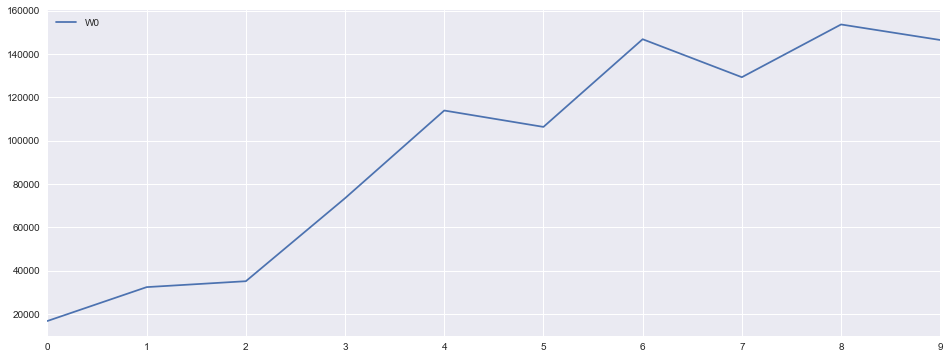

In [12]:
import pandas as pd
import seaborn as sns
%matplotlib inline

tmp = pd.DataFrame(GD)
tmp.iloc[:500,:1].plot(figsize=(16,6))

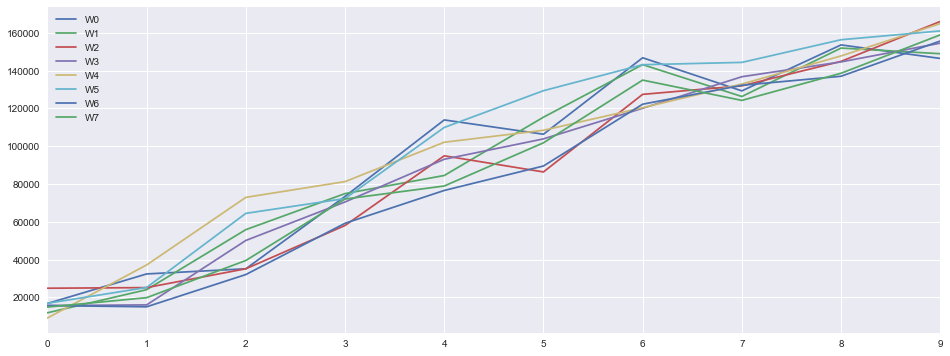

In [13]:
tmp.plot(figsize=(16,6))

#### 策略测试

In [14]:
state_size = [50, 58, 5]
action_size = 3

tf.reset_default_graph()
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        A = Access(state_size, action_size)
        W = ConvACNet(A, state_size, action_size, 'AC')
        A.restore(sess,'model/saver_1.ckpt')
        W.init_network(sess)
        env = Account()
        state = env.reset()
        net_value = []
        reward_list = []
        for _ in range(1400):
            action = W.get_deterministic_policy_action(sess, state)
            reward, state, done = env.step(action)
            reward_list.append(reward)
            net_value.append(env.total_value)

graph AC
INFO:tensorflow:Restoring parameters from model/saver_1.ckpt


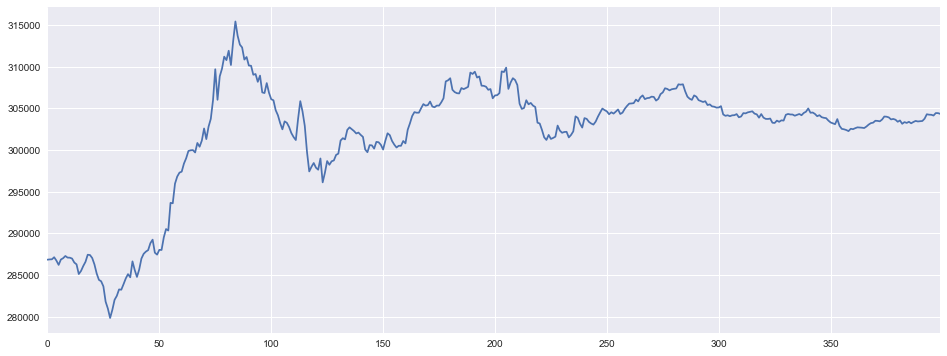

In [15]:
pd.Series(net_value[1000:]).plot(figsize=(16,6))